### **Project Team:** Raghad Dawoud — Muna Dini — Maha Alsubaie.


## CNN Model with Oversampling Minority Classes and Augmentation   (based on research paper methodology)



# Alzheimer's Disease MRI Classification Project

## Project Goal
The goal of this project is to detect and classify different stages of Alzheimer’s disease using brain MRI images.

---

## About MRI and Dataset
MRI (Magnetic Resonance Imaging) is a medical imaging technique that captures detailed 3D images of the brain.  
For this project, MRI volumes from **347 patients** were sliced along the z-axis.  

- **Slices used:** 100–160 from each patient (61 slices per patient)  
- **Total images:** ~80,000 slices  
- **Class labels:** Non-Demented, Very Mild Demented, Mild Demented, Demented  
- **Purpose of slices:** These slices contain the most informative regions of the brain for Alzheimer’s detection.

---

####Citation
OASIS-1: Cross-Sectional — https://doi.org/10.1162/jocn.2007.19.9.1498

sources: https://www.kaggle.com/code/metinusta/oasis-alzheimer-s-detection-eda

In [ ]:
!pip install opendatasets
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
import opendatasets as od
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_fscore_support, accuracy_score,
    precision_score, recall_score, f1_score
)
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")

SEED = 45
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.config.experimental.enable_op_determinism()
od.download("https://www.kaggle.com/datasets/ninadaithal/imagesoasis/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: munadini
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/ninadaithal/imagesoasis


100%|██████████| 1.23G/1.23G [00:12<00:00, 108MB/s]


# Loading and Preparing the Dataset

### Functions for Preparing and Loading the OASIS MRI Dataset

The following functions are used to process the OASIS Alzheimer's MRI dataset:

1. **`validate_filename(filename)`**  
   Checks if a filename matches the expected OASIS dataset pattern.

2. **`get_info_from_filename(filename)`**  
   Extracts `patient_id`, `mr_id`, `scan_id`, and `layer_id` from a valid filename.

3. **`create_ref_df(dataset_path)`**  
   Builds a reference DataFrame containing image paths, labels, patient/session/scan/layer IDs.

4. **`load_images(ref_df)`**  
   Loads images from disk as grayscale numpy arrays.  
   Returns three lists: `images` (arrays), `labels` (class labels), and `paths` (file paths).

5. **`get_image_stats(images, labels, paths)`**  
   Computes per-image statistics: mean pixel intensity, standard deviation, width, height, and histogram skewness.  
   Returns a DataFrame with these statistics along with the label and path for each image.


In [ ]:
def validate_filename(filename):
    """
    Validate filename to ensure it is a valid OASIS Alzheimer's dataset filename.
    """
    pattern = re.compile(r'OAS1_\d+_MR\d+_mpr-\d+_\d+\.jpg')
    return bool(pattern.match(filename))

In [ ]:
def get_info_from_filename(filename):
    """
    Extract patient_id, mr_id, scan_id, and layer_id from filename.
    """
    # Use raw string to avoid SyntaxWarning
    pattern = re.compile(r'OAS1_(\d+)_MR(\d+)_mpr-(\d+)_(\d+)\.jpg')
    match = pattern.match(filename)

    if not match:
        raise ValueError(f"Filename '{filename}' does not match expected pattern")

    patient_id = match.group(1)
    mr_id = match.group(2)
    scan_id = match.group(3)
    layer_id = match.group(4)

    return patient_id, mr_id, scan_id, layer_id

In [ ]:
def create_ref_df(dataset_path):
    """
    Create a reference dataframe with the following columns:
    - path: path to the image
    - label: label of the image
    - patient_id: patient id
    - mr_id: session number of the mr
    - scan_id: id of scan in the corresponding mr session
    - layer_id: layer id of the image -> [100, 160]
    """
    paths, labels = [], []
    patient_ids, mr_ids, scan_ids, layer_ids = [], [], [], []

    for folder in os.listdir(dataset_path):
        for file in os.listdir(os.path.join(dataset_path, folder)):
            if not validate_filename(file):
                raise ValueError(f'Invalid filename: {folder}/{file}')

            patient_id, mr_id, scan_id, layer_id = get_info_from_filename(file)

            paths.append(os.path.join(dataset_path, folder, file))
            labels.append(folder)
            patient_ids.append(patient_id)
            mr_ids.append(mr_id)
            scan_ids.append(scan_id)
            layer_ids.append(layer_id)

    ref_df = pd.DataFrame({ 'path': paths,'label': labels, 'patient_id': patient_ids, 'mr_id': mr_ids,'scan_id': scan_ids, 'layer_id': layer_ids})
    ref_df = ref_df.astype({'path': 'string','label': 'string','patient_id': 'int64','mr_id': 'int64','scan_id': 'int64','layer_id': 'int64' })

    return ref_df

In [ ]:
# Create the reference DataFrame for all images and then load the images
ref_df = create_ref_df('/content/imagesoasis/Data')

# Train / Val / Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# Split into train+val and test
train_val_df, test_df = train_test_split(
    ref_df, test_size=0.15, stratify=ref_df['label'], random_state=SEED
)
# Split train+val into train and validation
train_df, val_df = train_test_split(
    train_val_df, test_size=0.15, stratify=train_val_df['label'], random_state=SEED
)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


Train: 62450, Val: 11021, Test: 12966



# Identify Minority Classes and Oversample
Minority classes are oversampled based on a research paper’s recommendation,  
applying the same strategy to this dataset to address class imbalance.


In [ ]:

print("\n=== Class Distribution BEFORE Oversampling ===")
display(train_df['label'].value_counts())

# Define minority classes (adjust based on your data)
minority_classes = ['Mild Dementia', 'Moderate Dementia']

# Separate majority and minority
train_majority_df = train_df[~train_df['label'].isin(minority_classes)]
train_minority_df = train_df[train_df['label'].isin(minority_classes)]

# Oversample minority classes
aug_rows = []
# Replicate Mild Dementia samples
mild_samples = train_minority_df[train_minority_df['label'] == 'Mild Dementia']
aug_rows.extend(mild_samples.to_dict('records') * 1)  # 1x oversampling

# Replicate Moderate Dementia samples (usually most rare)
moderate_samples = train_minority_df[train_minority_df['label'] == 'Moderate Dementia']
aug_rows.extend(moderate_samples.to_dict('records') * 2)  # 5x oversampling

# Combine original minority samples with replicated ones
train_minority_oversampled_df = pd.concat([
    train_minority_df,
    pd.DataFrame(aug_rows)
], ignore_index=True)

# Combine majority and oversampled minority
train_balanced_df = pd.concat([
    train_majority_df,
    train_minority_oversampled_df
], ignore_index=True)

print("\n=== Class Distribution AFTER Oversampling ===")
display(train_balanced_df['label'].value_counts())


=== Class Distribution BEFORE Oversampling ===


,count
label,
Non Demented,48567
Very mild Dementia,9916
Mild Dementia,3614
Moderate Dementia,353



=== Class Distribution AFTER Oversampling ===


,count
label,
Non Demented,48567
Very mild Dementia,9916
Mild Dementia,7228
Moderate Dementia,1059


# 4.Data Preprocessing

We applied **oversampling** to the minority classes to slightly increase their representation and enhance model performance. After that, **data augmentation** was applied to **all training images** to introduce variations such as flips, shifts, zooms, and brightness changes, helping the model generalize better.



In [ ]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 64

# Medically safe augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    brightness_range=[0.90, 1.10],
    fill_mode='constant',
    cval=0
)




val_test_datagen = ImageDataGenerator(rescale=1./255)


# Data Generators

# Training generator
train_gen = train_datagen.flow_from_dataframe(
    train_balanced_df,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

# Validation generator
val_gen = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

# Test generator
test_gen = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)



Found 66770 validated image filenames belonging to 4 classes.
Found 11021 validated image filenames belonging to 4 classes.
Found 12966 validated image filenames belonging to 4 classes.


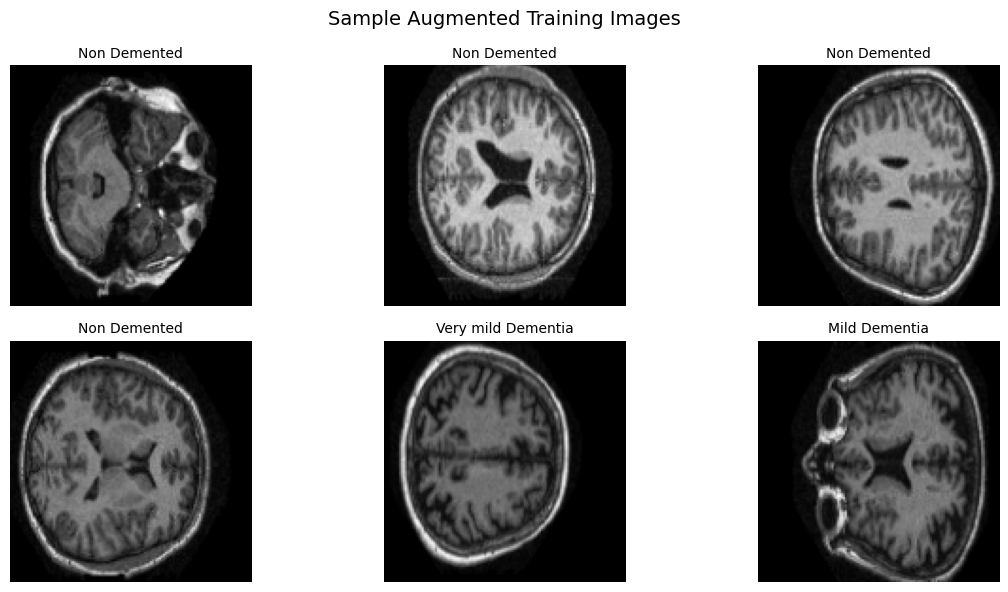

In [ ]:
# Get a batch of augmented images and labels
augmented_images, augmented_labels = next(train_gen)

# Number of images to display
num_images = 6
plt.figure(figsize=(12, 6))

for i in range(num_images):
    plt.subplot(2, 3, i+1)
    # Reshape to remove channel dimension for grayscale
    plt.imshow(augmented_images[i].reshape(IMG_SIZE[0], IMG_SIZE[1]), cmap='gray')
    # Decode one-hot labels
    label_index = np.argmax(augmented_labels[i])
    label_name = list(train_gen.class_indices.keys())[label_index]
    plt.title(label_name, fontsize=10)
    plt.axis('off')

plt.suptitle("Sample Augmented Training Images", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
# Print generator info
for name, gen in zip(['TRAIN','VAL','TEST'], [train_gen, val_gen, test_gen]):
    print(f"\n=== {name} ===")
    print(f"Images: {gen.n}, Batches: {len(gen)}, Shape: {gen.image_shape}, Classes: {list(gen.class_indices.keys())}")



=== TRAIN ===
Images: 66770, Batches: 1044, Shape: (128, 128, 1), Classes: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']

=== VAL ===
Images: 11021, Batches: 173, Shape: (128, 128, 1), Classes: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']

=== TEST ===
Images: 12966, Batches: 203, Shape: (128, 128, 1), Classes: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']


# 5.Model Building (CNN)

In [ ]:
# =========================
model = Sequential()
model.add(Input(shape=(128,128,1)))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))

model.add(Dense(4, activation='softmax'))
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,476 (12.61 MB)

 Trainable params: 3,305,028 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

# Model Training

In [ ]:

# Stop training early if validation loss doesn't improve for 5 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
# Reduce learning rate by half if validation loss doesn't improve for 3 epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train the model with the training generator and validate on validation generator
history = model.fit(
    train_gen,           # training data generator
    validation_data=val_gen,  # validation data generator
    epochs=10,           # maximum number of epochs
    callbacks=[early_stop, reduce_lr]  # list of callbacks to apply during training
)




Epoch 1/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 274s 259ms/step - accuracy: 0.7305 - loss: 0.9592 - val_accuracy: 0.8357 - val_loss: 0.5316 - learning_rate: 3.0000e-04
Epoch 2/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 273s 262ms/step - accuracy: 0.8051 - loss: 0.5875 - val_accuracy: 0.8611 - val_loss: 0.4250 - learning_rate: 3.0000e-04
Epoch 3/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 265s 253ms/step - accuracy: 0.8447 - loss: 0.4799 - val_accuracy: 0.8689 - val_loss: 0.4354 - learning_rate: 3.0000e-04
Epoch 4/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 265s 254ms/step - accuracy: 0.8833 - loss: 0.4189 - val_accuracy: 0.9310 - val_loss: 0.3255 - learning_rate: 3.0000e-04
Epoch 5/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 265s 254ms/step - accuracy: 0.9064 - loss: 0.3973 - val_accuracy: 0.9406 - val_loss: 0.3402 - learning_rate: 3.0000e-04
Epoch 6/10
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 273s 262ms/step - accuracy: 0.9262 - loss: 0.3746 - val_accuracy: 0.9691 - val_loss: 0.2795 - learning_rate: 3.0000e-04
Epoch 7/10
1044/1044 ━━━━━━━

#Plot Training History

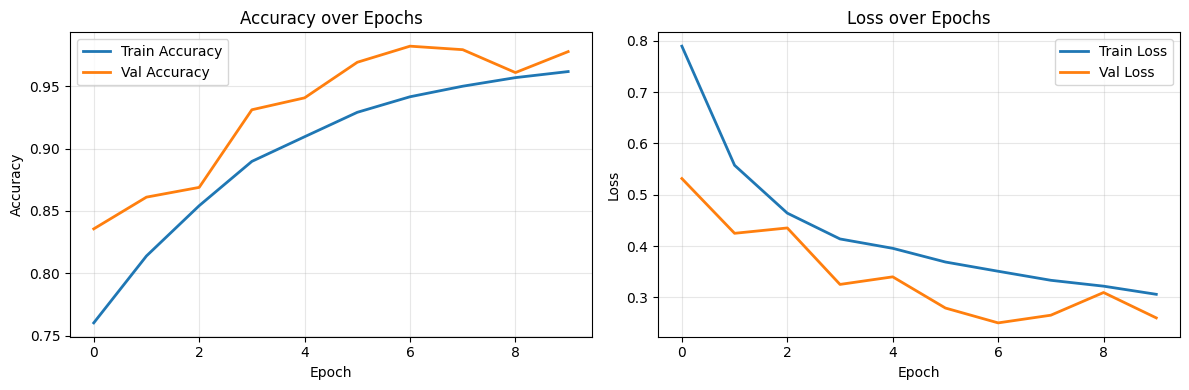

In [ ]:
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



# Overall Model Performance


203/203 ━━━━━━━━━━━━━━━━━━━━ 18s 87ms/step


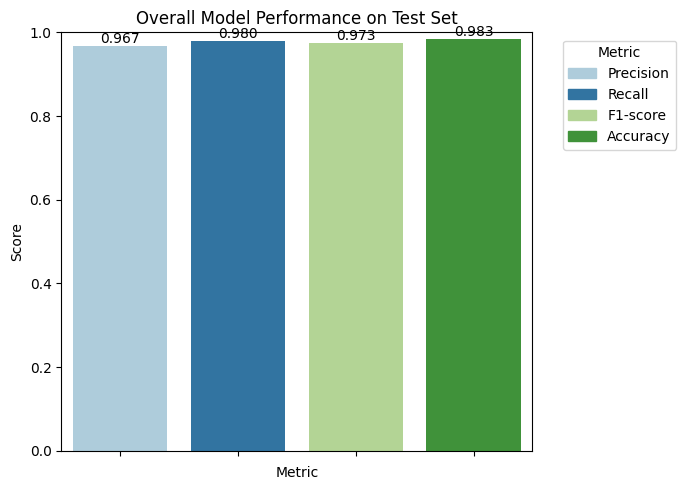

In [ ]:
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes

# Get class names from the generator
classes = list(test_gen.class_indices.keys())

# =========================
# Overall Model Performance
# =========================
overall_precision = precision_score(y_true, y_pred, average='macro')
overall_recall = recall_score(y_true, y_pred, average='macro')
overall_f1 = f1_score(y_true, y_pred, average='macro')
overall_accuracy = accuracy_score(y_true, y_pred)

overall_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-score', 'Accuracy'],
    'Score': [overall_precision, overall_recall, overall_f1, overall_accuracy]
})

# Plot
plt.figure(figsize=(7,5))
ax = sns.barplot(
    data=overall_df,
    x='Metric',
    y='Score',
    palette='Paired'
)

plt.title("Overall Model Performance on Test Set")
plt.ylim(0, 1)
plt.ylabel("Score")
ax.set_xticklabels([])

# Add value labels on top of each bar
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.3f}",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='bottom',
        fontsize=10
    )

# Legend
handles = [
    plt.Rectangle((0,0),1,1, color=ax.patches[i].get_facecolor())
    for i in range(len(overall_df))
]

plt.legend(
    handles,
    overall_df["Metric"],
    title="Metric",
    loc='center left',
    bbox_to_anchor=(1.05, 0.85)
)

plt.tight_layout()
plt.show()

## Bar Chart of the Performance per Class

Found 62450 validated image filenames belonging to 4 classes.

=== TRAIN METRICS (on original training data) ===
                Class  Precision    Recall  F1-score  Accuracy
0       Mild Dementia   0.998856  0.965966  0.982135  0.985428
1   Moderate Dementia   0.977839  1.000000  0.988796  0.985428
2        Non Demented   0.993999  0.989108  0.991548  0.985428
3  Very mild Dementia   0.940775  0.973981  0.957090  0.985428

Train Accuracy: 0.9854

=== TEST METRICS ===
                Class  Precision    Recall  F1-score  Accuracy
0       Mild Dementia   0.995856  0.961333  0.978290   0.98311
1   Moderate Dementia   0.948052  1.000000  0.973333   0.98311
2        Non Demented   0.993508  0.986513  0.989999   0.98311
3  Very mild Dementia   0.931691  0.973774  0.952268   0.98311

Test Accuracy: 0.9831


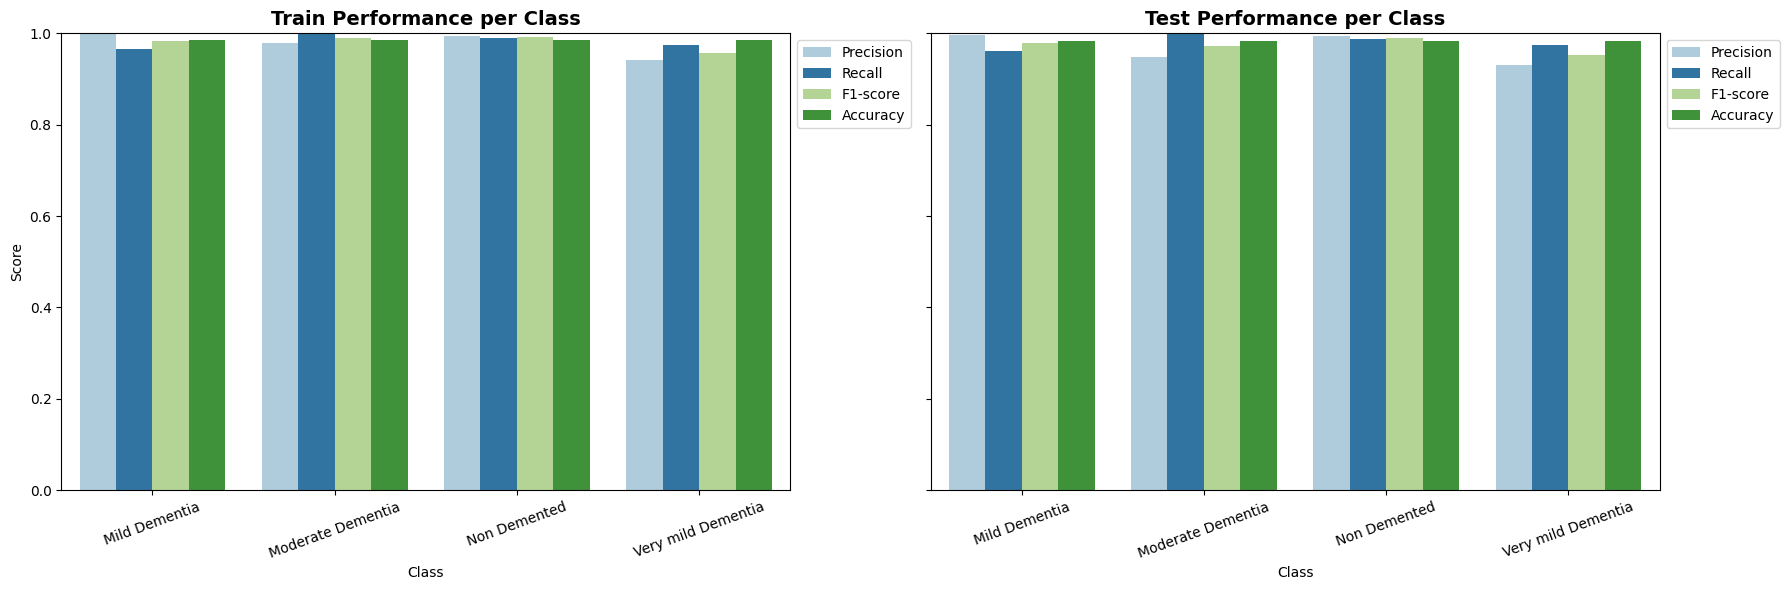

In [ ]:
# =========================
# Train vs Test Performance Comparison
# =========================
# Create evaluation generator for training (non-augmented)
train_gen_eval = val_test_datagen.flow_from_dataframe(
    train_df,  # Use ORIGINAL train_df for evaluation
    x_col='path',
    y_col='label',
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Ensure class order matches generator
classes_ordered = [k for k,v in sorted(train_gen_eval.class_indices.items(), key=lambda item: item[1])]

# Function to compute metrics and confusion matrix
def get_metrics_and_cm(model, generator, classes_ordered):
    generator.reset()
    steps = int(np.ceil(generator.n / generator.batch_size))
    y_pred_probs = model.predict(generator, steps=steps, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = generator.classes

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=range(len(classes_ordered)), zero_division=0
    )
    accuracy = accuracy_score(y_true, y_pred)

    metrics_df = pd.DataFrame({
        'Class': classes_ordered,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'Accuracy': [accuracy]*len(classes_ordered)
    })

    cm = confusion_matrix(y_true, y_pred)

    return metrics_df, cm

# Compute metrics and confusion matrices for train and test
train_metrics_df, train_cm = get_metrics_and_cm(model, train_gen_eval, classes_ordered)
test_metrics_df, test_cm = get_metrics_and_cm(model, test_gen, classes_ordered)

# Print metric values
print("\n=== TRAIN METRICS (on original training data) ===")
print(train_metrics_df)
print(f"\nTrain Accuracy: {train_metrics_df['Accuracy'].iloc[0]:.4f}")

print("\n=== TEST METRICS ===")
print(test_metrics_df)
print(f"\nTest Accuracy: {test_metrics_df['Accuracy'].iloc[0]:.4f}")

# Melt for Seaborn
train_melted = train_metrics_df.melt(
    id_vars='Class',
    value_vars=['Precision','Recall','F1-score','Accuracy'],
    var_name='Metric',
    value_name='Score'
)
test_melted = test_metrics_df.melt(
    id_vars='Class',
    value_vars=['Precision','Recall','F1-score','Accuracy'],
    var_name='Metric',
    value_name='Score'
)

# Plot per-class metrics side by side
fig, axes = plt.subplots(1, 2, figsize=(18,6), sharey=True)

sns.barplot(data=train_melted, x='Class', y='Score', hue='Metric', palette='Paired', ax=axes[0])
axes[0].set_title("Train Performance per Class", fontsize=14, fontweight='bold')
axes[0].set_ylim(0,1)
axes[0].set_ylabel("Score")
axes[0].tick_params(axis='x', rotation=20)
axes[0].legend(loc='upper left', bbox_to_anchor=(1,1))

sns.barplot(data=test_melted, x='Class', y='Score', hue='Metric', palette='Paired', ax=axes[1])
axes[1].set_title("Test Performance per Class", fontsize=14, fontweight='bold')
axes[1].set_ylim(0,1)
axes[1].set_ylabel("Score")
axes[1].tick_params(axis='x', rotation=20)
axes[1].legend(loc='upper left', bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show()




## Confusion Matrices: Train vs Test

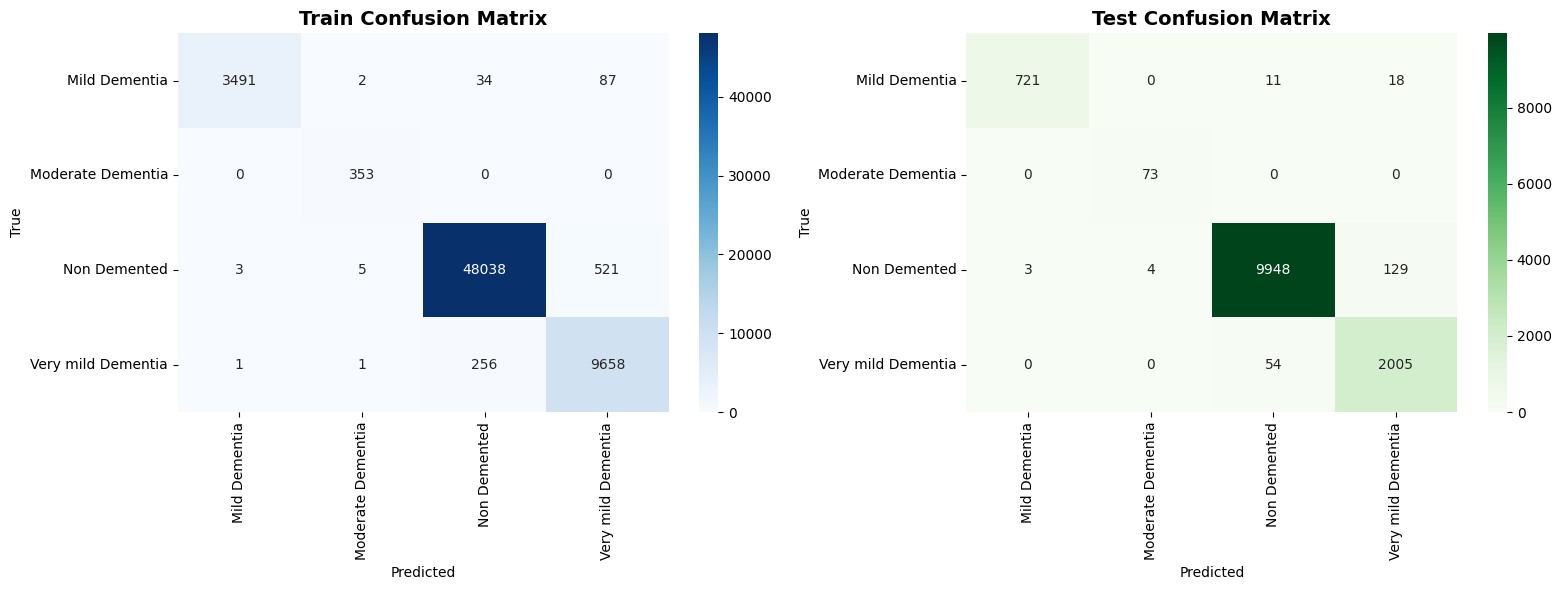

In [ ]:
# Plot confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(16,6))

sns.heatmap(train_cm, annot=True, fmt='d', xticklabels=classes_ordered, yticklabels=classes_ordered, cmap='Blues', ax=axes[0])
axes[0].set_title("Train Confusion Matrix", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(test_cm, annot=True, fmt='d', xticklabels=classes_ordered, yticklabels=classes_ordered, cmap='Greens', ax=axes[1])
axes[1].set_title("Test Confusion Matrix", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()


##Random Test Predictions

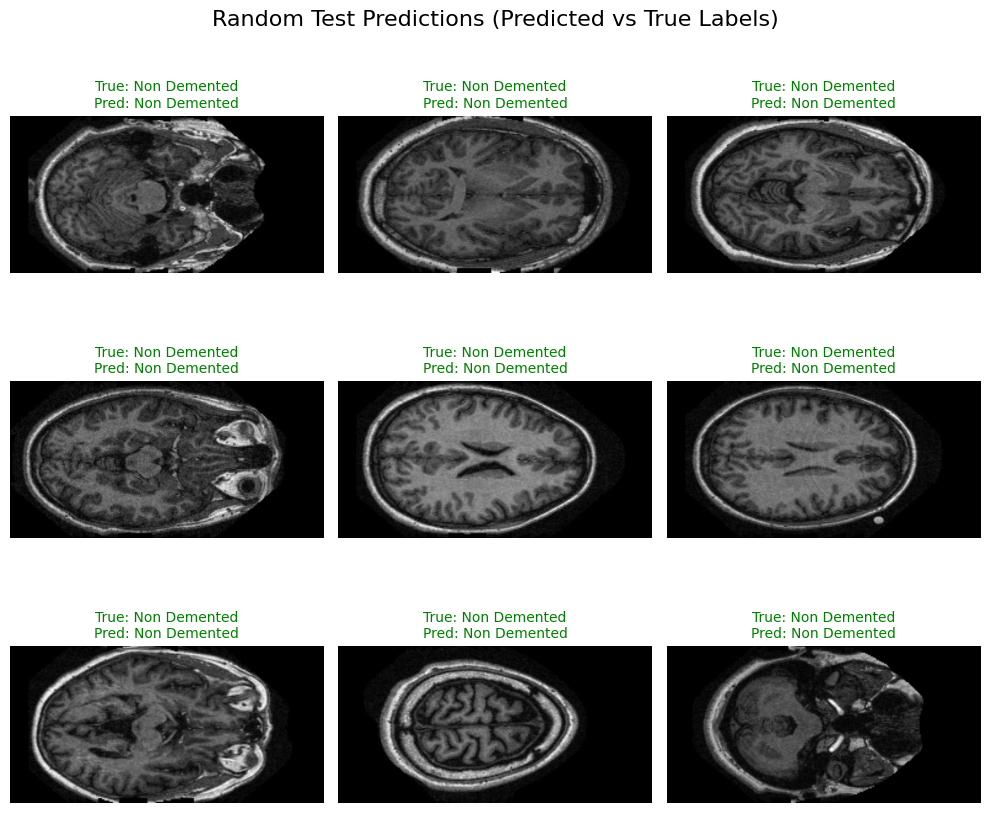

In [ ]:
plt.figure(figsize=(10, 9))

# Choose 9 random test indices
random_indices = random.sample(range(len(test_df)), 9)

for i, idx in enumerate(random_indices):
    # Load image
    img_path = test_df.iloc[idx]['path']
    true_label = test_df.iloc[idx]['label']

    img = Image.open(img_path).convert('L')
    resized_img = img.resize(IMG_SIZE)
    img_array = np.array(resized_img) / 255.0
    img_array = img_array.reshape(1, IMG_SIZE[0], IMG_SIZE[1], 1)

    # Prediction
    pred = model.predict(img_array, verbose=0)
    pred_label = classes[np.argmax(pred)]

    # Plot
    plt.subplot(3, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(
        f"True: {true_label}\nPred: {pred_label}",
        fontsize=10,
        color="green" if pred_label == true_label else "red"
    )

plt.suptitle("Random Test Predictions (Predicted vs True Labels)", fontsize=16)
plt.tight_layout()
plt.show()



# CNN Model Performance Summary

The CNN model achieves **98.5% train accuracy** and **98.3% test accuracy**, with per-class precision ranging from **0.93 to 0.99** and recall from **0.96 to 1.00**. Even the minority class, *Moderate Dementia*, achieves precision **0.948** and recall **1.00**, demonstrating effective handling of class imbalance. Compared to Phase 1, where overall accuracy was ~96% and the minority class recall was only ~0.53, Phase 2 shows a significant improvement, highlighting the impact of oversampling and augmentation. Validation and test metrics closely match training, indicating strong generalization, making the model highly reliable in accurately classifying all dementia stages with minimal errors.


